In [1]:
# jupyter nbconvert --to script NeuralSparse2.ipynb
# ./run_neuralsprase.sh 
# ./run_neuralsprase.sh >> log.txt

In [2]:
all_dataset = [
    "Cornell",
    "Texas",
    "Wisconsin",
    "reed98",
    "amherst41",
    "penn94",
    "Roman-empire",
    "cornell5",
    "Squirrel",
    "johnshopkins55",
    "Actor",
    "Minesweeper",
    "Questions",
    "Chameleon",
    "Tolokers",
    "Amazon-ratings",
    "genius",
    "pokec",
    "arxiv-year",
    "snap-patents",
    "ogbn-proteins",
    "Cora",
    "DBLP",
    "Computers",
    "PubMed",
    "Cora_ML",
    "SmallCora",
    "CS",
    "Photo",
    "Physics",
    "CiteSeer",
    "wiki",
    "Reddit"
    "moon"
]

dataset_name = 'moon'


In [3]:
import argparse


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataset', type=str, default=dataset_name, choices=all_dataset, help='dataset')
    parser.add_argument('--epochs', type=int, default=600,  help='epochs')
    parser.add_argument('--k', type=int, default=2,  help='neigborhood size')
#     parser.add_argument('--nosparsify', action='store_false') # True
#     parser.add_argument('--nolog', action='store_false') #True

    parser.add_argument('--nosparsify',default = True) # True
    parser.add_argument('--nolog', default = True) #True
    

    return parser.parse_known_args()

args,_ = parse_args()

log = args.nolog


In [4]:
import os
import sys
import math
import copy 
import torch 
import random
DEBUG = False
import numpy as np
import torch_sparse
import pandas as pd 
import pickle as pkl
from tqdm import tqdm
import time
import networkx as nx
from dgl import DGLGraph
from scipy import linalg
from pathlib import Path
from torch import Tensor
import scipy.sparse as sp
from random import randint
from dgl import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from scipy import sparse, stats
from scipy.sparse import csgraph
from scipy.sparse import csr_matrix
from dgl import from_networkx, DGLGraph
from torch_geometric.utils import scatter
from dgl.data import citation_graph as citegrh
from torch_geometric.typing import SparseTensor
from torch_geometric.utils import to_undirected
from torch_geometric.utils import remove_self_loops
from sklearn.metrics.pairwise import cosine_similarity
# from ipynb.fs.full.Dataset import get_data_from_dataset
# from ipynb.fs.full.Dataset import get_data_from_dataset,train_val_test_mask
from ogb.nodeproppred import Evaluator, PygNodePropPredDataset
from typing import Callable, List, NamedTuple, Optional, Tuple, Union
from torch_geometric.utils import add_self_loops,add_remaining_self_loops
# from ipynb.fs.full.SpectralSparsifier import EffectiveResistance, LocalEffectiveResistance, get_sparse_adj_matrix

In [5]:
import torch
from contextlib import contextmanager
import subprocess
import re

# # At the start of your script
# torch.cuda.reset_peak_memory_stats()  # Reset memory statistics

# # ... your training loop ...

# # Get max memory used (in bytes)
# max_memory = torch.cuda.max_memory_allocated()
# print(f"Max GPU memory used: {max_memory / 1024**2:.2f} MB")

# # Optionally, get memory by device if using multiple GPUs
# for i in range(torch.cuda.device_count()):
#     max_memory = torch.cuda.max_memory_allocated(i)
#     print(f"Max GPU memory used on device {i}: {max_memory / 1024**2:.2f} MB")


# @contextmanager
# def track_memory_usage(description="", device=None):
#     if device is None:
#         device = torch.cuda.current_device()
#     torch.cuda.synchronize(device)
#     torch.cuda.reset_peak_memory_stats(device)
#     yield
#     torch.cuda.synchronize(device)
#     max_memory = torch.cuda.max_memory_allocated(device)
#     print(f"{description} Max GPU memory used: {max_memory / 1024**2:.2f} MB")
    
def get_gpu_memory_usage():
    result = subprocess.check_output(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits,noheader'])
    memory_usage = [int(x) for x in result.decode('utf-8').strip().split('\n')]
    return memory_usage

# Call this periodically during training to track memory usage
get_gpu_memory_usage()

[1655]

In [6]:
import DeviceDir

DIR, RESULTS_DIR = DeviceDir.get_directory()
device, NUM_PROCESSORS = DeviceDir.get_device()

In [7]:
from ipynb.fs.full.SGSLoadDataset import LOAD_DATASET

#DATASET_NAME = "Wisconsin"
DATASET_NAME = args.dataset
data, dataset  = LOAD_DATASET(DIR, DATASET_NAME)
num_classes = max(data.y).item()+1

if len(data.train_mask.shape)>1:
    index = 0
    data.train_mask = data.train_mask[:,index]
    data.val_mask = data.val_mask[:,index]
    if DATASET_NAME == 'wiki':
        None
    else:
        data.test_mask = data.test_mask[:,index]

moon N: 100 E: 596 F: 2 C: 2 d: 5.96 lr: 0.20 i: False s: False u: True


In [8]:
from ipynb.fs.full.Moon import MoonDataset
from ipynb.fs.full.SGSLoadDataset import train_val_test_mask

DATASET_NAME = "moon"
# Optimized Moon setup for NeuralSparse
dataset = MoonDataset(n_samples=150, degree=4, train=0.3, h = 0.2)
data = dataset[0]

if "train_mask" not in data.__dict__["_store"]:
    data = train_val_test_mask(data, train=0.3, val=0.3, test=0.4, random_state=False)

num_classes = max(data.y).item() + 1


In [9]:
import os
import  scipy.sparse as sp
import numpy as np
import torch
import torch
import torch.nn as nn
import sys
import pickle as pkl
import numpy as np
import os
import torch.nn.functional as F
import os
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.sparse import coo_matrix
from torch_sparse import SparseTensor
import dgl.sparse as dglsp

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

_LAYER_UIDS = {}

def get_layer_uid(layer_name=''):
    """Helper function, assigns unique layer IDs."""
    if layer_name not in _LAYER_UIDS:
        _LAYER_UIDS[layer_name] = 1
        return 1
    else:
        _LAYER_UIDS[layer_name] += 1
        return _LAYER_UIDS[layer_name]

def sparse_dropout(x, rate, noise_shape):
    """
    Dropout for sparse tensors.
    """
    random_tensor = 1 - rate
    random_tensor += torch.rand(noise_shape, dtype=x.dtype, device=x.device)
    dropout_mask = torch.floor(random_tensor).bool()
    pre_out = x.coalesce()  # Ensure sparse tensor is in coalesced form
    retained_values = pre_out.values() * dropout_mask.float()
    return torch.sparse_coo_tensor(pre_out.indices(), retained_values * (1./(1 - rate)), pre_out.size())

def dot(x, y, sparse=False):
    """
    Wrapper for torch.matmul (sparse vs dense).
    """
    if sparse:
        res = torch.sparse.mm(x, y)
    else:
        res = torch.matmul(x, y)
    return res

class Dense(nn.Module):
    """Dense layer in PyTorch."""
    def __init__(self, input_dim, output_dim, dropout=0.0, act=F.relu, bias=False, activation=F.relu, featureless=False):
        super(Dense, self).__init__()
        self.act = act
        self.featureless = featureless
        self.dropout = dropout
        self.bias = bias

        # Weight initialization
        self.weights_ = nn.Parameter(torch.FloatTensor(input_dim, output_dim))
        nn.init.xavier_uniform_(self.weights_)

        if self.bias:
            self.bias_param = nn.Parameter(torch.FloatTensor(output_dim))
            nn.init.zeros_(self.bias_param)
        else:
            self.bias_param = None

    def forward(self, inputs):
        x = F.dropout(inputs, self.dropout, training=self.training)

        # transform
        output = torch.matmul(x, self.weights_)

        # bias
        if self.bias_param is not None:
            output += self.bias_param

        return self.act(output)


class GraphConvolution(nn.Module):
    """Graph convolution layer in PyTorch."""
    def __init__(self, input_dim, output_dim, dropout=0.0, is_sparse_inputs=False, activation=F.relu, bias=False, featureless=False):
        super(GraphConvolution, self).__init__()
        self.dropout = dropout
        self.activation = activation
        self.is_sparse_inputs = is_sparse_inputs
        self.featureless = featureless
        self.bias = bias

        # Weight initialization
        self.weights_ = nn.Parameter(torch.FloatTensor(input_dim, output_dim))
        nn.init.xavier_uniform_(self.weights_)

        if self.bias:
            self.bias_param = nn.Parameter(torch.FloatTensor(output_dim))
            nn.init.zeros_(self.bias_param)
        else:
            self.bias_param = None

    def forward(self, inputs,training):
        x, support_ = inputs

        # Apply dropout
        if training:
            x = F.dropout(x, self.dropout)

        # Convolve
        pre_sup = dot(x, self.weights_, sparse=self.is_sparse_inputs)
        output = dot(support_, pre_sup, sparse=self.is_sparse_inputs)
#         output = dot(support_, pre_sup, sparse=False)

        # Bias
        if self.bias_param is not None:
            output += self.bias_param

        return self.activation(output)

In [11]:
def add_noisy_edge(shape, size, nb_noising_edges):
    noise_row = np.random.choice(range(size), nb_noising_edges)
    noise_col = np.random.choice(range(size), nb_noising_edges)
    noise_data = np.ones_like(noise_row)
    noise_adj = sp.coo_matrix((noise_data, (noise_row, noise_col)), shape=shape)
    return noise_adj

def preprocess_features(features):
    # Assuming features is a NumPy array, normalize if necessary
    return torch.tensor(features, dtype=torch.float32)

def sample_mask(idx, size):
    # Create a mask for training, validation, and testing
    mask = np.zeros(size, dtype=bool)
    mask[idx] = True
    return torch.tensor(mask, dtype=torch.bool)

def load_data(dataset_str):
    # Placeholder function, should load your dataset appropriately
    pass

In [12]:
def parse_index_file(filename):
    index = []
    with open(filename, 'r') as f:
        for line in f:
            index.append(int(line.strip()))
    return index

def sample_mask(idx, size):
    # Create a mask for training, validation, and testing
    mask = np.zeros(size, dtype=bool)
    mask[idx] = True
    return torch.tensor(mask, dtype=torch.bool)

def preprocess_features(features):
    return torch.tensor(features, dtype=torch.float32)

def load_data(dataset_str, directory):
    file_location = os.path.join(directory, "ind.{}.test.index".format(dataset_str))
    test_idx_reorder = parse_index_file(file_location)
    test_idx_range = np.sort(test_idx_reorder)
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for name in names:
        file_path = os.path.join(directory, "ind.{}.{}".format(dataset_str, name))
        with open(file_path, 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))
    x, y, tx, ty, allx, ally, graph = tuple(objects)
    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    idx_test = test_idx_range.tolist()
    idx_train = range(140)
    idx_val = range(len(ally) - 500, len(ally))

    return x, y, tx, ty, allx, ally, adj, test_idx_range,features,labels,idx_train,idx_val,idx_test

In [13]:
import torch
import torch.nn.functional as F
from sklearn import metrics

def masked_softmax_cross_entropy(preds, labels, mask):
    """
    Softmax cross-entropy loss with masking.
    """
    loss = F.cross_entropy(preds, labels, reduction='none')  # No reduction to apply mask manually
    mask = mask.float()
    mask /= mask.mean()  # Normalize mask
    loss *= mask
    return loss.mean()

def masked_accuracy(preds, labels, mask):
    """
    Accuracy with masking.
    """
    correct_prediction = (preds.argmax(dim=1) == labels.argmax(dim=1)).float()
    mask = mask.float()
    mask /= mask.mean()  # Normalize mask
    correct_prediction *= mask
    return correct_prediction.mean()

def softmax_cross_entropy(preds, labels):
    """
    Softmax cross-entropy loss.
    """
    loss = F.cross_entropy(preds, labels)
    return loss

def sigmoid_cross_entropy(preds, labels):
    """
    Sigmoid cross-entropy loss.
    """
    labels = labels.float()
    loss = F.binary_cross_entropy_with_logits(preds, labels)
    return loss.mean()

def accuracy(preds, labels):
    """
    Accuracy.
    """
    correct_prediction = (preds.argmax(dim=1) == labels.argmax(dim=1)).float()
    return correct_prediction.mean()

def calc_f1(y_pred, y_true):
    """
    F1 score calculation.
    """
    y_pred = (y_pred > 0.5).float()  # Convert predictions to binary (0 or 1)
    y_true = y_true.float()
    return metrics.f1_score(y_true.cpu().numpy(), y_pred.cpu().numpy(), average="micro")

In [14]:
# # import torch
# # import torch.nn as nn
# # import torch.nn.functional as F
# # import dgl
# # import dgl.sparse as dglsp


# class GumbleGCN(nn.Module):
#     def __init__(self, adj_matrix, shape, input_dim, output_dim, k, dropout=0.):
#         super(GumbleGCN, self).__init__()

#         self.adj_matrix = adj_matrix  # DGL SparseMatrix
#         self.shape = shape
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.k = k
#         self.hidden1 = 16
#         self.hidden2 = 8
#         self.weighted = True
#         self.weight_decay = 0.0
#         self.flag_value = 0

#         self.fc_dim = nn.Linear(2 * self.input_dim, 32)

#         # Define layers
#         self.layer1 = GraphConvolution(
#             input_dim=self.input_dim,
#             output_dim=self.hidden1,
#             activation=F.relu,
#             dropout=dropout,
#             is_sparse_inputs=True  # Enable sparse inputs
#         )

#         self.layer2 = GraphConvolution(
#             input_dim=self.hidden1,
#             output_dim=self.hidden2,
#             activation=F.relu,
#             dropout=dropout,
#             is_sparse_inputs=True # Enable sparse inputs
#         )

#         self.layer3 = Dense(
#             input_dim=self.hidden2,
#             output_dim=self.output_dim,
#             activation=lambda x: x,
#             dropout=dropout
#         )

#         # Sparse layers for adjacency matrix
#         self.fb_input = nn.Linear(self.input_dim, self.hidden1)
#         self.slayer1 = nn.Linear(2 * self.hidden1 + 1, 32)
#         self.slayer2 = nn.Linear(32, 1, bias=True)

#     def sample_gumbel(self, shape, eps=1e-20):
#         """Sample from Gumbel(0, 1)."""
#         U = torch.rand(shape, dtype=torch.float32, device=self.adj_matrix.device)
#         return -torch.log(-torch.log(U + eps) + eps)

#     def gumbel_softmax_sample(self, logits, temperature, is_train):
#         """Draw a sample from the Gumbel-Softmax distribution."""
#         r = self.sample_gumbel(logits.val.shape)  # Use .val to access non-zero values
#         if is_train:
#             values = torch.log(logits.val) + r
#         else:
#             values = torch.log(logits.val)
#         values /= temperature

#         # Create a new SparseMatrix with updated values
#         A = dglsp.spmatrix(logits.indices(), values, self.shape)

#         # Apply softmax to the SparseMatrix
#         A_softmax = dglsp.softmax(A, dim=1)

#         return A_softmax

#     def forward(self, inputs, training=None):
#         x, label, mask, temperature = inputs

#         # Ensure the adjacency matrix is coalesced
#         adj_matrix = self.adj_matrix.coalesce()

#         # Sparse adjacency operations
#         f1 = self.fb_input(x[adj_matrix.indices()[0]])
#         f2 = self.fb_input(x[adj_matrix.indices()[1]])
#         auv = adj_matrix.values().unsqueeze(-1)  # Use .values() instead of .val

#         temp = torch.cat([f1, f2, auv], dim=-1)
#         temp = F.relu(self.slayer1(temp))
#         temp = self.slayer2(temp)
#         z = temp.view(-1)

#         # Create and normalize adjacency matrix
#         A = dglsp.spmatrix(adj_matrix.indices(), z, self.shape)
#         A_softmax = dglsp.softmax(A, dim=1)
#         y = self.gumbel_softmax_sample(A_softmax, temperature, training)
        

#         # Convert sparse matrix to dense for top-k selection
#         y_dense = y.to_dense()
#         #print(y_dense.shape)
#         top_k_v, top_k_i = torch.topk(y_dense, self.k, dim=-1)
#         kth = torch.min(top_k_v, dim=-1)[0] + 1e-10
#         kth = kth.unsqueeze(-1).expand_as(y_dense)
#         mask2 = (y_dense >= kth).float()

#         if self.weighted:
#             dense_support = mask2 * y_dense
#         else:
#             raise ValueError("Unweighted mode is not supported with sparse matrices!")
                

#         # Add self-loops to sparse matrix
#         self_loops = torch.eye(self.shape[0], device=y.device)
#         dense_support = dense_support + self_loops

#         # Normalize the dense matrix
#         row_sum = dense_support.sum(dim=-1) + 1e-6
#         d_inv_sqrt = torch.pow(row_sum, -0.5)
#         d_mat_inv_sqrt = torch.diag(d_inv_sqrt)
#         support = torch.matmul(d_mat_inv_sqrt, dense_support)
#         support = torch.matmul(support, d_mat_inv_sqrt)

        
#         # Pass through layers
#         hidden = self.layer1((x, support), training)
#         hidden = self.layer2((hidden, support), training)
#         output = self.layer3(hidden)

#         # Weight decay loss
#         loss = sum(self.weight_decay * torch.sum(param**2) for param in self.layer1.parameters())

#         # Cross-entropy loss
#         loss += masked_softmax_cross_entropy(output, label, mask)

#         # Accuracy
#         acc = masked_accuracy(output, label, mask)

#         if self.flag_value == 0:
#             num_edges_retained = mask2.sum().item()
#             total_edges = self.adj_matrix._nnz()
#             percentage_retained = (num_edges_retained / total_edges) * 100
#             print(f"Percentage of edges retained: {percentage_retained:.2f}%")
#             self.flag_value = 1

#         return loss, acc


In [15]:
import torch
import torch.nn.functional as F

class GumbleGCN(nn.Module):
    def __init__(self, adj_matrix, shape, input_dim, output_dim, k, dropout=0.):
        super(GumbleGCN, self).__init__()

        #self.adj_matrix = adj_matrix.coalesce()  # Should be a sparse tensor now
        self.adj_matrix = adj_matrix  # Should be a sparse tensor now
        self.shape = shape
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.k = k
        self.hidden1 = 64
        self.hidden2 = 64
        self.weighted = True
        self.weight_decay = 0.0
        self.flag_value = 0
        self.dropout = nn.Dropout(0.2)
        
        self.fc_dim = nn.Linear(2*self.input_dim, 32)

        # Define layers
        self.layer1 = GraphConvolution(
            input_dim=self.input_dim,
            output_dim=self.hidden1,
            activation=F.relu,
            dropout=dropout,
            is_sparse_inputs=True
        )

        self.layer2 = GraphConvolution(
            input_dim=self.hidden1,
            output_dim=self.hidden2,
            #output_dim=self.output_dim,
            activation=F.relu,
            #activation=F.relu,
            dropout=dropout,
            is_sparse_inputs=True
        )

        self.layer3 = Dense(
            input_dim=self.hidden2,
            output_dim=self.output_dim,
            activation=lambda x: x,
            dropout=dropout
        )

        # Define additional dense layers for the sparse representation
        self.fb_input = nn.Linear(self.input_dim, self.hidden1)
        self.slayer1 = nn.Linear(2*self.hidden1+1, 32)
        self.slayer2 = nn.Linear(32, 1, bias=True)

    def sample_gumbel(self, shape, eps=1e-20):
        """Sample from Gumbel(0, 1)"""
        U = torch.rand(shape, dtype=torch.float32, device=self.adj_matrix.device)
        return -torch.log(-torch.log(U + eps) + eps)

    def gumbel_softmax_sample(self, logits, temperature, is_train):
        if is_train:
            noise = torch.rand_like(logits.values(), dtype=logits.dtype)
            noise = -torch.log(-torch.log(noise + 1e-20) + 1e-20)
            logits = logits + noise

        # Coalesce the sparse tensor before applying softmax
        logits = logits.coalesce()  # Ensure the tensor is coalesced

        # Apply softmax on sparse tensor values
        A_softmax = F.softmax(logits.values(), dim=0)  # Apply softmax only on values

        # Return as a sparse tensor
        A_softmax_sparse = torch.sparse.FloatTensor(logits.indices(), A_softmax, logits.shape)

        return A_softmax_sparse

    def forward(self, inputs, training=None):
        x, label, mask, temperature = inputs

        # Get the feature vectors based on adjacency matrix indices
        f1 = self.dropout(F.relu(self.fb_input(x[self.adj_matrix._indices()[0]])))
        f2 = self.dropout(F.relu(self.fb_input(x[self.adj_matrix._indices()[1]])))

        # Augment features with adjacency values
        auv = self.adj_matrix._values().unsqueeze(-1)
        temp = torch.cat([f1, f2, auv], dim=-1)

        # Apply layers to the augmented features
        temp = F.relu(self.slayer1(temp))
        temp = self.slayer2(temp)
        z = temp.view(-1)

        # Construct the sparse adjacency matrix A
        A = torch.sparse.FloatTensor(self.adj_matrix.indices(), z, self.shape)
        A_softmax = self.gumbel_softmax_sample(A, temperature, training)

#         with torch.no_grad():
#             A_softmax_coalesced = A_softmax.coalesce()        
#             values, indices = A_softmax_coalesced.values(), A_softmax_coalesced.indices()        
#             n_rows = A_softmax_coalesced.size(0)
#             mask_values = torch.zeros_like(values)
#             top_k_values, top_k_indices = torch.topk(values, k, dim=-1, largest=True, sorted=True)
            
#             print(top_k_indices.shape)
            
#             mask_values.scatter_(0, top_k_indices, 1)  # Set 1 at the top-k indices positions
#             mask2 = torch.sparse.FloatTensor(indices, mask_values, A_softmax_coalesced.shape)
        
    
#        ---- FOR LOOP -- SPARSE
#         #with torch.no_grad():            
#         A_softmax_coalesced = A_softmax.coalesce()
#         values, indices = A_softmax_coalesced.values(), A_softmax_coalesced.indices()
#         n_rows = A_softmax_coalesced.size(0)
#         mask_values = torch.full_like(values, 0)  # Initialize with 1e-10

#         row_indices = indices[0]
#         unique_rows = torch.unique(row_indices)

#         for row in unique_rows:
#             row_mask = (row_indices == row)
#             row_values = values[row_mask]
#             row_indices_in_row = torch.nonzero(row_mask).squeeze()

# #                 print(row_indices_in_row)

#             if row_values.numel() > 0:

#                 if row_values.numel() == 1:
#                     mask_values[row_indices_in_row] = row_values  # Directly assign the single value                    
#                 else:                    
#                     top_k_values, top_k_indices = torch.topk(row_values, min(k, row_values.numel()), largest=True, sorted=True)                    
# #                         print(top_k_indices.shape)                    
#                     mask_values[row_indices_in_row[top_k_indices]] = top_k_values

#         mask2 = torch.sparse.FloatTensor(indices, mask_values, A_softmax_coalesced.shape)


#         ------without loop SPARSE--
#          with torch.no_grad():
           
        if args.nosparsify:
    
            # Assuming k is predefined and A_softmax is a sparse tensor
            A_softmax_coalesced = A_softmax.coalesce()
            values, indices = A_softmax_coalesced.values(), A_softmax_coalesced.indices()
            n_rows = A_softmax_coalesced.size(0)

            # Extract row indices and count occurrences per row
            row_indices = indices[0]
            row_count = torch.bincount(row_indices, minlength=n_rows)

            # Prepare an auxiliary tensor for grouping
            row_offsets = torch.cumsum(row_count, dim=0) - row_count
            max_count = row_count.max().item()
            aux_indices = torch.arange(max_count, device=values.device).unsqueeze(0).expand(n_rows, max_count)
            valid_mask = aux_indices < row_count.unsqueeze(1)

            # Compute valid indices for sorting and grouping
            global_indices = row_offsets.unsqueeze(1) + aux_indices
            global_indices = global_indices[valid_mask]

            # Sort values globally by rows
            sorted_values, sorted_order = torch.sort(values[global_indices], descending=True)
            sorted_rows = row_indices[global_indices][sorted_order]


            # Compute top-k mask dynamically for valid indices only
            row_k = torch.minimum(torch.tensor(k, device=values.device), row_count)
            top_k_mask = torch.arange(max_count, device=values.device).unsqueeze(0) < row_k.unsqueeze(1)
            top_k_mask = top_k_mask[valid_mask]  # Apply the mask to only valid positions

            # Use the corrected top-k mask to index global_indices
            top_k_global_indices = global_indices[sorted_order][top_k_mask]

            # Update mask values
            mask_values = torch.zeros_like(values)
            #mask_values[top_k_global_indices] = values[top_k_global_indices]
            mask_values[top_k_global_indices] = 1

            #print(sum(mask_values))

            # Construct final sparse tensor
            mask2 = torch.sparse_coo_tensor(indices, mask_values, A_softmax_coalesced.shape)
            
#             print("global_indices shape:", global_indices.shape)
#             print("sorted_order shape:", sorted_order.shape)
#             print("top_k_mask shape:", top_k_mask.shape)

            
        
        #print(mask2.shape)

        
        #support = A
        #support = mask2
        
        #support = A.coalesce()
        #support = A
        
        
#         values, indices = A_softmax_coalesced.values(), A_softmax_coalesced.indices()

#         # Top-k selection from sparse matrix (without converting to dense)
#         top_k_values, top_k_indices = torch.topk(values, self.k, dim=-1, largest=True, sorted=True)

#         # Masking and normalization on top-k values
#         kth = torch.min(top_k_values, dim=-1)[0] + 1e-10
#         kth = kth.unsqueeze(-1).expand_as(top_k_values)
#         mask2 = (top_k_values >= kth).float()

#         # Dense support calculation with weighted top-k values
#         if self.weighted:
#             dense_support = mask2 * top_k_values
#         else:
#             raise ValueError("Unweighted mode is not supported with sparse matrices!")

#         # Add self-loops to the sparse matrix (ensuring it's n x n)
        

#         
#         support = A
        
        
#         if args.nosparsify:
#             identity_indices = torch.eye(self.shape[0], dtype=torch.long).nonzero().T  # Get indices of identity matrix (non-zero elements)
#             identity_values = torch.ones(identity_indices.shape[1], dtype=torch.float32)  # Values at those indices (1)
#             self_loops = torch.sparse_coo_tensor(identity_indices, identity_values, self.shape).to(device)
            
#             support  = A * mask2 + self_loops 
#         else:            
#             support = A + self_loops 

    
        
        support = A
#         support  = mask2 + self_loops 

        #self_loops = torch.eye(self.shape[0], device=device)

#         # Ensure the self-loops matrix matches the size of dense_support (n x n)
#         dense_support = dense_support + self_loops

#         # Normalize the support matrix: D^-1/2 * A * D^-1/2
#         row_sum = dense_support.sum(dim=-1) + 1e-6  # Avoid NaN
#         d_inv_sqrt = torch.pow(row_sum, -0.5)
#         d_mat_inv_sqrt = torch.diag(d_inv_sqrt)

#         # Calculate the normalized support matrix
#         ad = torch.mm(dense_support, d_mat_inv_sqrt)
#         ad_t = ad.transpose(0, 1)
#         support = torch.matmul(ad_t, d_mat_inv_sqrt)

        # Now pass the normalized support matrix through layers
        hidden = self.layer1((x, support), training)
        hidden = self.layer2((hidden, support), training)
        output = self.layer3(hidden)

        # Weight decay loss
        loss = 0
        for param in self.layer1.parameters():
            loss += self.weight_decay * torch.sum(param ** 2)

        # Cross-entropy loss
        loss += masked_softmax_cross_entropy(output, label, mask)

        # Accuracy
        acc = masked_accuracy(output, label, mask)

        return loss, acc


## Initialize the Model

In [16]:
data = data.to("cpu")

In [17]:
print(data.train_mask.sum(),data.val_mask.sum(),data.test_mask.sum())
print(data)

tensor(45) tensor(45) tensor(60)
Data(x=[150, 2], edge_index=[2, 846], y=[150], train_mask=[150], val_mask=[150], test_mask=[150], edge_weight=[846, 1])


In [18]:
num_classes = data.y.max().item() + 1
labels = torch.zeros(data.y.size(0), num_classes)
labels.scatter_(1, data.y.unsqueeze(1), 1)


y_train = np.zeros(labels.shape)
y_val = np.zeros(labels.shape)
y_test = np.zeros(labels.shape)

train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask

print(data.train_mask.sum(),val_mask.sum(),test_mask.sum())

y_train[data.train_mask, :] = labels[data.train_mask, :]
y_val[data.val_mask, :] = labels[data.val_mask, :]
y_test[data.test_mask, :] = labels[data.test_mask, :]

edge_index = data.edge_index
row, col = edge_index
indices = torch.stack([row, col], dim=0)
values = torch.ones(indices.size(1), dtype=torch.float32)
num_nodes = data.num_nodes
shape = torch.Size([num_nodes, num_nodes])
adj_tensor = torch.sparse_coo_tensor(indices, values, shape)
# f1 = data.x[adj_tensor._indices()[0]]
# f2 = data.x[adj_tensor._indices()[1]]

# auv = adj_tensor._values().unsqueeze(-1)
# temp = torch.cat([f1, f2, auv], dim=-1)

train_label = torch.tensor(y_train).to(device)
train_mask = train_mask.clone().detach().to(device)  # Fix for the warning
val_label = torch.tensor(y_val).to(device)
val_mask = val_mask.clone().detach().to(device)  # Fix for the warning
test_label = torch.tensor(y_test).to(device)
test_mask = test_mask.clone().detach().to(device)  # Fix for the warning
features = data.x.clone().detach().float().to(device)  # Fix for the warning and specify dtype
dropout = 0  # args.dropout
feature_tensor = data.x.clone().detach().float().to(device)

tensor(45) tensor(45) tensor(60)


In [19]:
k = args.k

adj_tensor = adj_tensor.coalesce()

def compute_edges():
    # Assuming k is predefined and A_softmax is a sparse tensor
        
    values, indices = adj_tensor.values(), adj_tensor.indices()
    n_rows = adj_tensor.size(0)

    # Extract row indices and count occurrences per row
    row_indices = indices[0]
    row_count = torch.bincount(row_indices, minlength=n_rows)

    # Prepare an auxiliary tensor for grouping
    row_offsets = torch.cumsum(row_count, dim=0) - row_count
    max_count = row_count.max().item()
    aux_indices = torch.arange(max_count, device=values.device).unsqueeze(0).expand(n_rows, max_count)
    valid_mask = aux_indices < row_count.unsqueeze(1)

    # Compute valid indices for sorting and grouping
    global_indices = row_offsets.unsqueeze(1) + aux_indices
    global_indices = global_indices[valid_mask]

    # Sort values globally by rows
    sorted_values, sorted_order = torch.sort(values[global_indices], descending=True)
    sorted_rows = row_indices[global_indices][sorted_order]


    # Compute top-k mask dynamically for valid indices only
    row_k = torch.minimum(torch.tensor(k, device=values.device), row_count)
    top_k_mask = torch.arange(max_count, device=values.device).unsqueeze(0) < row_k.unsqueeze(1)
    top_k_mask = top_k_mask[valid_mask]  # Apply the mask to only valid positions

    # Use the corrected top-k mask to index global_indices
    top_k_global_indices = global_indices[sorted_order][top_k_mask]

    # Update mask values
    mask_values = torch.zeros_like(values)
    #mask_values[top_k_global_indices] = values[top_k_global_indices]
    mask_values[top_k_global_indices] = 1

    sparse_num_edge = sum(mask_values).item()
    
    
    print(f'E = {data.num_edges}, S = {sparse_num_edge}, Ratio = {sparse_num_edge/data.num_edges:.4f}')
    
    return 

compute_edges()

E = 846, S = 299.0, Ratio = 0.3534


In [20]:
# data = data.to(device)
adj_tensor = adj_tensor.to(device)
# f1 = f1.to(device)
# f2 = f2.to(device)

In [21]:
if log == True:
    print("GumbleGCN Model Parameters")
    print(f"Shape : {shape}")
    print(f"Input Dim : {features.shape[-1]}")
    print(f"Output Dim : {labels.shape[-1]}")
    print(f"K : {k}")
    print(f"Adjacency Sparse Tensor : {adj_tensor}")

model = GumbleGCN(adj_tensor, shape=shape, input_dim=features.shape[-1], output_dim=labels.shape[-1], k=k, dropout=0.2).to(device)

None


GumbleGCN Model Parameters
Shape : torch.Size([150, 150])
Input Dim : 2
Output Dim : 2
K : 2
Adjacency Sparse Tensor : tensor(indices=tensor([[  0,   0,   0,  ..., 149, 149, 149],
                       [ 60,  76, 110,  ...,  33,  73, 118]]),
       values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                      1., 1., 1., 1., 1., 1., 1., 1., 1

In [22]:
# From config
temp_N = 20
temp_r = 2e-3
early_stopping = 50
# Optimizer setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

persist = 0
best_test_acc = 0
epochs =  args.epochs
init_temp = 0.05


In [23]:
# for epoch in range(epochs):
#     if epoch % 50 == 0:
#         decay_temp = np.exp(-1 * 1e-3 * epoch)
#         temp = max(0.05, decay_temp)
#     model.train()  # Set model to training mode
#     optimizer.zero_grad()  # Clear previous gradients
#     # Forward pass
#     loss, acc = model((features, train_label, train_mask, temp))

#     # Backward pass
#     loss.backward()  # Compute gradients
#     optimizer.step()  # Update weights

#     print(epoch, 'temp', temp, 'loss', loss.item(), 'acc', acc.item())
#     # if epoch % 1 == 0:
#     #     print(epoch, 'temp', temp, 'loss', loss.item(), 'acc', acc.item(), '\tval:', val_acc.item())


In [24]:
EpochTimes = []

best_val_acc = 0
best_test_throughout = 0
best_state = None
best_test_at_val = 0
train_losses = []
num_iteration = epochs
patience = early_stopping
patience_count = 0

for epoch in range(epochs):
    start = time.time()

    if epoch % temp_N == 0:
        decay_temp = np.exp(-1 * temp_r * epoch)
        temp = max(0.05, decay_temp)

    model.train()
    optimizer.zero_grad()  # Zero out the gradients
    loss, acc = model((features, train_label, train_mask, temp))

    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    EpochTimes.append(time.time() - start)

    model.eval()
    with torch.no_grad():  # Disable gradient computation for validation
        test_loss, test_acc = model((features, test_label, test_mask, 1.0))
        val_loss, val_acc = model((features, val_label, val_mask, 1.0))

    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        best_test_at_val = test_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        patience_count = 0
    else:
        patience_count += 1

    if test_acc > best_test_throughout:
        best_test_throughout = test_acc

    if epoch >= 5 and np.std(train_losses[-5:]) < 1e-4:
        num_iteration = epoch

    if log == True and epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():0.4f}, Train Acc: {acc.item():0.4f}, Val Acc: {val_acc.item():0.4f},  Test Acc: {test_acc.item():0.4f}')

    if patience_count >= patience:
        print(f"Early stopping at epoch {epoch} (best val acc={best_val_acc:.4f})")
        num_iteration = epoch
        break

if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    with torch.no_grad():
        final_loss, final_test_acc = model((features, test_label, test_mask, 1.0))
else:
    final_test_acc = best_test_at_val

print("Best test accuracy throughout:", best_test_throughout)
print("Mean epoch time: ", np.mean(EpochTimes))
print(f'Final test accuracy (best val): {final_test_acc:.4f}')
print(f'Iteration: {num_iteration}')


Epoch 0, Loss: 0.6931, Train Acc: 0.5111, Val Acc: 0.5333,  Test Acc: 0.4667
Epoch 50, Loss: 0.1805, Train Acc: 0.9111, Val Acc: 0.8889,  Test Acc: 0.9167
Epoch 100, Loss: 0.1102, Train Acc: 0.9556, Val Acc: 0.8667,  Test Acc: 0.9333
Epoch 150, Loss: 0.0420, Train Acc: 0.9778, Val Acc: 0.8667,  Test Acc: 0.9500
Epoch 200, Loss: 0.0109, Train Acc: 1.0000, Val Acc: 0.9111,  Test Acc: 0.9333
Epoch 250, Loss: 0.0018, Train Acc: 1.0000, Val Acc: 0.9111,  Test Acc: 0.9500
Early stopping at epoch 263 (best val acc=0.9333)
Best test accuracy throughout: tensor(0.9667, device='cuda:0')
Mean epoch time:  0.006289662736834902
Final test accuracy (best val): 0.9500
Iteration: 263


In [25]:
# print(best_test_acc)

In [26]:
#torch.save(model.state_dict(), 'easy_checkpoint.pth')  # Save model weights

In [27]:
# #model.load_state_dict(torch.load('easy_checkpoint.pth'))
# model.eval()
# with torch.no_grad(
# ):
#     test_loss, test_acc = model((features, test_label, test_mask, 1.0))
# print(f'Test Loss: {test_loss.item()}, Test Acc: {test_acc.item()}')

In [28]:
a= [0.7838, 0.50, 0.7568, 0.8108, 0.7297]
# mean_a = np.mean(a)
# std_dev_a = np.std(a)
# print(f'{mean_a:.4f} +/- {std_dev_a:.4f}')

In [29]:
its = [189,104,102, 78]
print(f'{np.mean(its):.4f} +/- {np.std(its):.4f}')

118.2500 +/- 42.1092


In [30]:
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import torch

# Font + global sizing
font_dir = Path.home() / '.local' / 'share' / 'fonts' / 'msttcore'
font_paths = []
if font_dir.exists():
    font_paths = list(font_dir.glob('*.ttf')) + list(font_dir.glob('*.TTF'))
    for font_path in font_paths:
        fm.fontManager.addfont(str(font_path))

font_name = None
if font_paths:
    font_name = fm.FontProperties(fname=str(font_paths[0])).get_name()

if font_name:
    mpl.rcParams['font.family'] = font_name
    mpl.rcParams['font.serif'] = [font_name, 'Times New Roman', 'Times', 'DejaVu Serif']
else:
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']

FIGSIZE = (5, 5)
mpl.rcParams['figure.figsize'] = FIGSIZE

root_dir = Path.cwd()
if not (root_dir / 'visualization_utils').exists() and (root_dir.parent / 'visualization_utils').exists():
    sys.path.insert(0, str(root_dir.parent))

from visualization_utils.graph import (
    compute_graph_layout,
    count_edges_with_different_labels,
    plot_graph_two_class,
    visualize_graphs_side_by_side,
)
from visualization_utils.embeddings import (
    extract_embeddings,
    reduce_embeddings_2d,
    plot_embeddings_2d,
)
from visualization_utils.io import ensure_dir, save_figure
from visualization_utils.utils import select_two_classes


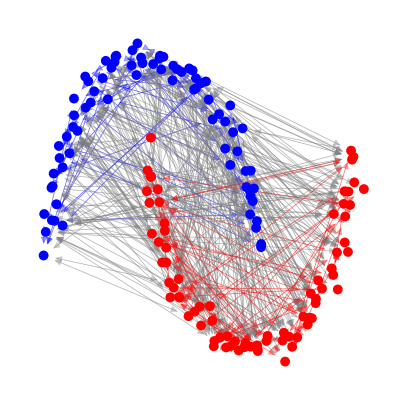

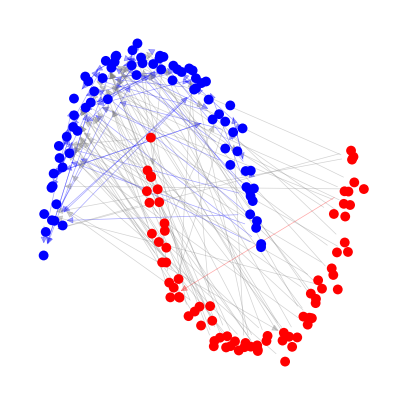

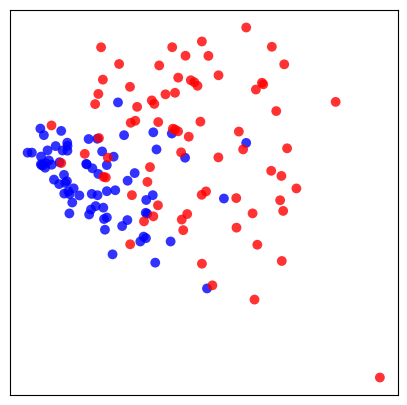

In [31]:
# NeuralSparse visualization helpers

def get_neuralsparse_edge_scores(model, data, temperature=1.0):
    model.eval()
    x = data.x.to(device)
    adj = model.adj_matrix
    with torch.no_grad():
        f1 = model.dropout(F.relu(model.fb_input(x[adj._indices()[0]])))
        f2 = model.dropout(F.relu(model.fb_input(x[adj._indices()[1]])))
        auv = adj._values().unsqueeze(-1)
        temp = torch.cat([f1, f2, auv], dim=-1)
        temp = F.relu(model.slayer1(temp))
        temp = model.slayer2(temp)
        z = temp.view(-1)
        A = torch.sparse.FloatTensor(adj.indices(), z, model.shape).to(device)
        A_softmax = model.gumbel_softmax_sample(A, temperature, False).coalesce()
    return A_softmax


def select_topk_per_node(edge_index, weights, num_nodes, k):
    selected = []
    for node in range(num_nodes):
        mask = edge_index[0] == node
        if mask.any():
            idx = mask.nonzero(as_tuple=False).view(-1)
            w = weights[idx]
            topk = min(k, w.numel())
            top_idx = idx[torch.topk(w, topk).indices]
            selected.append(top_idx)
    if selected:
        sel = torch.cat(selected)
    else:
        sel = torch.tensor([], dtype=torch.long)
    return edge_index[:, sel]


def get_neuralsparse_embeddings(model, data, support):
    model.eval()
    x = data.x.to(device)
    with torch.no_grad():
        h = model.layer1((x, support), False)
        h = model.layer2((h, support), False)
    return h.detach().cpu()

# Paper-ready figures (NeuralSparse)
fig_dir = ensure_dir('KDDFigures')
class_pair = select_two_classes(data.y, None)

A_softmax = get_neuralsparse_edge_scores(model, data, temperature=1.0)
edge_index_all = A_softmax.indices().cpu()
edge_weights = A_softmax.values().cpu()

k = 1

SPARSE_K = max(1, k)  # use training k for visualization
k_sparse = SPARSE_K
sampled_edge_index = select_topk_per_node(edge_index_all, edge_weights, data.num_nodes, k_sparse)




pos = compute_graph_layout(data, dataset_name=DATASET_NAME, seed=42)

fig_full, ax_full = plt.subplots(figsize=FIGSIZE)
plot_graph_two_class(
    data,
    ax=ax_full,
    pos=pos,
    class_pair=class_pair,
    dataset_name=DATASET_NAME,
#     title='Original dense graph (NeuralSparse)',
    node_size=50,
    highlight_colors=('blue', 'red'),
)
save_figure(fig_full, fig_dir / 'FullGraphNeuralsparse.pdf', dpi=300)

fig_sparse, ax_sparse = plt.subplots(figsize=FIGSIZE)
plot_graph_two_class(
    data,
    edge_index=sampled_edge_index,
    ax=ax_sparse,
    pos=pos,
    class_pair=class_pair,
    dataset_name=DATASET_NAME,
#     title='NeuralSparse subgraph (top-k per node)',
    node_size=50,
    highlight_colors=('blue', 'red'),
)
save_figure(fig_sparse, fig_dir / 'NeuralSparseSparseGraph.pdf', dpi=300)

embeddings = get_neuralsparse_embeddings(model, data, A_softmax)
emb_2d = reduce_embeddings_2d(embeddings, method='pca', random_state=42)
fig_emb, ax_emb = plt.subplots(figsize=FIGSIZE)
plot_embeddings_2d(
    emb_2d,
    data.y,
    class_pair=class_pair,
    ax=ax_emb,
#     title='NeuralSparse embeddings (PCA)',
    highlight_colors=('blue', 'red'),
)
save_figure(fig_emb, fig_dir / 'NeuralSparseEmbedding.pdf', dpi=300)

plt.show()


In [32]:
result  = count_edges_with_different_labels(data, sampled_edge_index)
print(f"Original graph: {result['original_graph']['different_label_edges']} edges with different labels "
              f"out of {result['original_graph']['total_edges']} total edges "
              f"(Edge homophily: {100-result['original_graph']['percentage']:.2f}%).")

print(f"Sampled graph: {result['sampled_graph']['different_label_edges']} edges with different labels "
      f"out of {result['sampled_graph']['total_edges']} total edges "
      f"(Edge homophily: {100-result['sampled_graph']['percentage']:.2f}%).")

Original graph: 570 edges with different labels out of 846 total edges (Edge homophily: 32.62%).
Sampled graph: 76 edges with different labels out of 150 total edges (Edge homophily: 49.33%).
